In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [237]:
df = pd.read_csv('244400404_effectifs-eleves-cleaned')
df=df[df['Nom du site']=='LEDRU ROLLIN/SARAH BERNHARDT']
df['Date']=pd.to_datetime(df['Date'])
df['Mois']= df['Date'].apply( lambda dt1 : dt1.month)
df['joursem']= df['Date'].apply( lambda dt1 : dt1.weekday())
df.sort_values('Date',inplace=True)
df.reset_index(inplace=True)
df.set_index('Date',inplace=True)
df.drop(columns=['RowNo','Type de site','RéelMed','RéelNorm','index'],inplace=True)
df.head()

,Prévision,Réel,Nom du site,An,Mois,joursem
Date,,,,,,
2011-01-03,305.0,267.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0
2011-01-04,315.0,297.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,1
2011-01-06,330.0,316.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,3
2011-01-07,315.0,304.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,4
2011-01-10,305.0,272.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0


In [238]:
df.describe()

,Prévision,Réel,An,Mois,joursem
count,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000
mean,443.178862,426.012873,2016.198509,6.197154,2.001355
std,72.253578,87.445591,3.340236,3.696597,1.579959
min,170.000000,106.000000,2011.000000,1.000000,0.000000
25%,402.000000,376.000000,2013.000000,3.000000,1.000000
50%,473.000000,441.000000,2016.000000,6.000000,2.000000
75%,498.000000,500.000000,2019.000000,10.000000,4.000000
max,631.000000,591.000000,2022.000000,12.000000,4.000000


<AxesSubplot:ylabel='Frequency'>

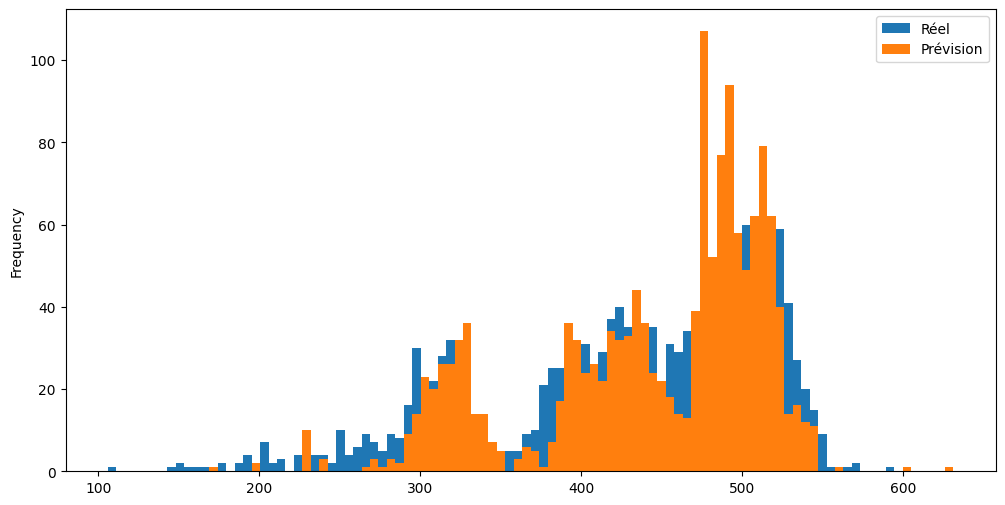

In [239]:
df[['Réel','Prévision']].plot.hist(bins=100, figsize=(12,6))

<AxesSubplot:xlabel='Date'>

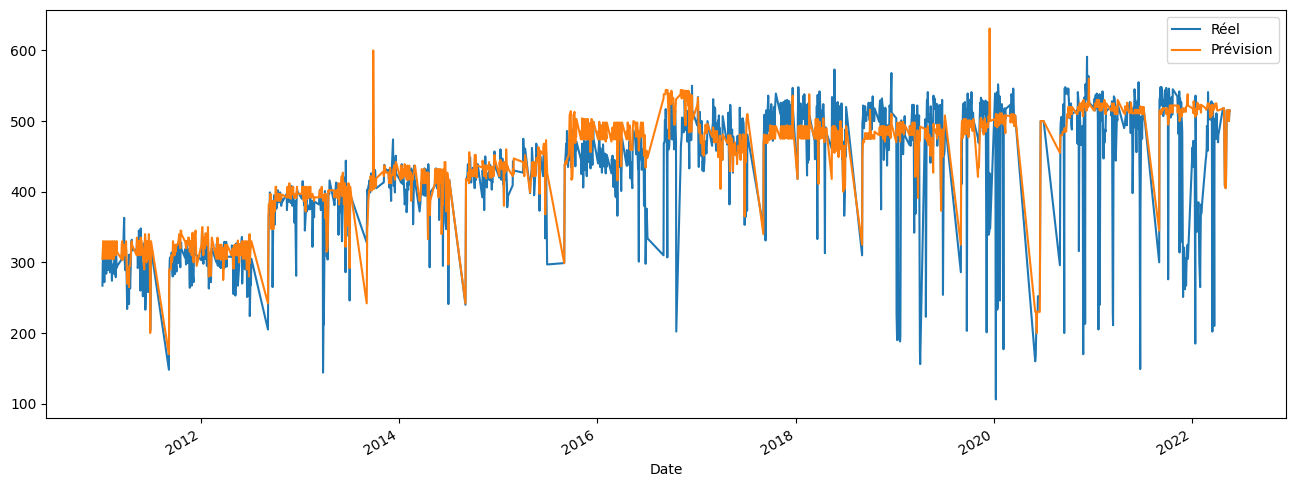

In [240]:
df[['Réel','Prévision']].plot(figsize=(16,6))

<AxesSubplot:xlabel='Date'>

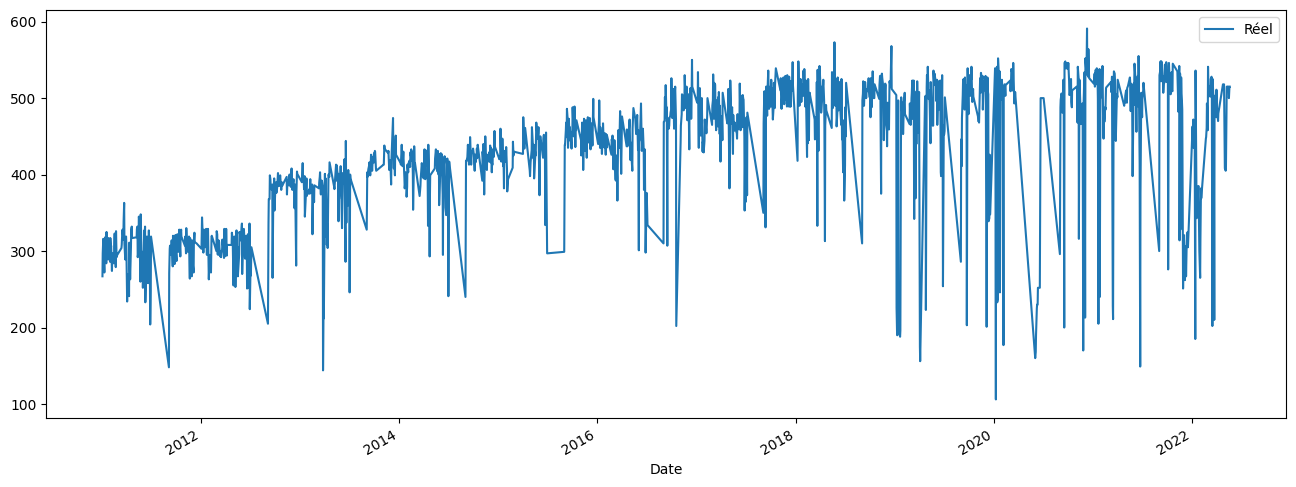

In [241]:
df[['Réel']].plot(figsize=(16,6))

In [242]:
df_calend=pd.read_csv('calendrier_saisons_vacances.csv')
df_calend['datetime']=pd.to_datetime(df_calend['datetime'])
df_calend.drop(columns='Unnamed: 0',inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac
0,2011-01-03,1,False,1,54
1,2011-01-04,1,False,2,53
2,2011-01-06,1,False,4,51
3,2011-01-07,1,False,5,50
4,2011-01-10,1,False,8,47


In [243]:
df_calend1=pd.read_csv('calendrier_fetes_juives.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1=df_calend1[['datetime', 'Fete Juive']]
df_calend1.head()

,datetime,Fete Juive
0,2011-03-21,Pourim
1,2011-04-20,Pessah
2,2011-06-09,Chavouot
3,2011-08-10,Jeûne
4,2011-09-30,Roch


In [244]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['Fete Juive'].fillna('-', inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive
0,2011-01-03,1,False,1,54,-
1,2011-01-04,1,False,2,53,-
2,2011-01-06,1,False,4,51,-
3,2011-01-07,1,False,5,50,-
4,2011-01-10,1,False,8,47,-


In [245]:
df_calend1=pd.read_csv('calendrier_ramadan.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1.drop(columns='Unnamed: 0',inplace=True)
df_calend1.head()

,ramadan,datetime
0,1,2021-04-13
1,1,2021-04-14
2,1,2021-04-15
3,1,2021-04-16
4,1,2021-04-17


In [246]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['ramadan'].fillna(0, inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan
0,2011-01-03,1,False,1,54,-,0.0
1,2011-01-04,1,False,2,53,-,0.0
2,2011-01-06,1,False,4,51,-,0.0
3,2011-01-07,1,False,5,50,-,0.0
4,2011-01-10,1,False,8,47,-,0.0


Maintenant, un peu de feature engineering :

In [247]:
df_calend['DepVac_J']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend['DepVac_S']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1%7 )
df_calend['AvVac_J']=df_calend['durée_AvantVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,1,False,8,47,-,0.0,4,1,4


In [248]:
df_calend.rename(columns={'datetime':'Date'},inplace=True)

In [249]:
df= pd.merge(df,df_calend, how='left', on='Date')
df.head()

,Date,Prévision,Réel,Nom du site,An,Mois,joursem,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,305.0,267.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,315.0,297.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,1,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,330.0,316.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,3,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,315.0,304.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,4,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,305.0,272.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0,1,False,8,47,-,0.0,4,1,4


In [250]:
df['Réel_J-1']=df['Réel'].shift(1)
df['Réel_J-2']=df['Réel'].shift(2)
df['Réel_J-3']=df['Réel'].shift(3)
df['Réel_J-4']=df['Réel'].shift(4)
df['Réel_J-5']=df['Réel'].shift(5)
df['Réel_J-1'].fillna(df['Réel'][0],inplace=True)
df['Réel_J-2'].fillna(df['Réel'][0],inplace=True)
df['Réel_J-3'].fillna(df['Réel'][0],inplace=True)
df['Réel_J-4'].fillna(df['Réel'][0],inplace=True)
df['Réel_J-5'].fillna(df['Réel'][0],inplace=True)
df.head()

,Date,Prévision,Réel,Nom du site,An,Mois,joursem,Saison,Problème,durée_DepuisVac,...,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J,Réel_J-1,Réel_J-2,Réel_J-3,Réel_J-4,Réel_J-5
0,2011-01-03,305.0,267.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0,1,False,1,...,-,0.0,1,1,4,267.0,267.0,267.0,267.0,267.0
1,2011-01-04,315.0,297.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,1,1,False,2,...,-,0.0,2,2,4,267.0,267.0,267.0,267.0,267.0
2,2011-01-06,330.0,316.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,3,1,False,4,...,-,0.0,4,4,4,297.0,267.0,267.0,267.0,267.0
3,2011-01-07,315.0,304.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,4,1,False,5,...,-,0.0,4,5,4,316.0,297.0,267.0,267.0,267.0
4,2011-01-10,305.0,272.0,LEDRU ROLLIN/SARAH BERNHARDT,2011,1,0,1,False,8,...,-,0.0,4,1,4,304.0,316.0,297.0,267.0,267.0


In [251]:
enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']])
enc.fit(df[['An','Mois','joursem','Fete Juive']])
enc.categories_

[array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12], dtype=int64),
 array([0, 1, 2, 3, 4], dtype=int64),
 array(['-', 'Chavouot', 'Hanoukkah', 'Pessah', 'Pourim', 'Roch', 'Simhat',
        'Soukkot', 'Yom'], dtype=object)]

In [252]:
# X = enc.transform(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']]).toarray()
X1 = enc.transform(df[['An','Mois','joursem','Fete Juive']]).toarray()
X2 = df[['Réel_J-1','Réel_J-2','Réel_J-3','Réel_J-4','Réel_J-5', 'DepVac_J', 'DepVac_S', 'AvVac_J']].to_numpy()
X = np.concatenate((X1,X2),axis=1, out=None)
y = df['Réel']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [254]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model_fit = model.fit(X_train, y_train)

In [255]:
model_fit.coef_

array([-6.48742456e+01, -4.95576517e+01, -1.74684981e+01, -1.02221958e+01,
        7.45483809e+00,  1.03344494e+01,  2.76304593e+01,  3.13827629e+01,
        1.02757111e+01,  1.82669666e+01,  2.10841474e+01,  1.56932564e+01,
       -8.82060472e+00,  8.37771871e-01, -3.40939764e+00, -2.19125498e+00,
        7.98666865e+00, -1.52046040e+01, -1.68744501e+01,  1.09311282e+01,
        1.35045731e+01,  8.06942170e+00,  5.17074790e+00,  8.15543768e+00,
        1.24900412e+01, -5.14520092e+01,  6.36443732e+00,  2.44420930e+01,
       -3.65441966e+00,  2.79572419e+01, -1.69053515e+01,  7.22507866e+00,
        4.91677728e+00, -6.18518352e+00,  1.41026884e+01, -4.64794737e+01,
        1.90226422e+01,  2.09187032e-01,  2.25935971e-02,  1.53655704e-01,
        9.27401809e-02,  8.22282750e-03,  3.27412185e+00, -9.36664275e-01,
        1.87536344e+00])

In [256]:
model_fit.intercept_

194.06023356089818

In [257]:
y_train_pred = model_fit.predict(X_train)
y_test_pred = model_fit.predict(X_test)

In [258]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [259]:
df_metric = pd.DataFrame( {'MSE': [mean_squared_error(y_train,y_train_pred), mean_squared_error(y_test,y_test_pred),mean_squared_error(df['Réel'],df['Prévision'])],
                           'RMSE': [sqrt(mean_squared_error(y_train,y_train_pred)), sqrt(mean_squared_error(y_test,y_test_pred)),sqrt(mean_squared_error(df['Réel'],df['Prévision']))],
                           'r2': [r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred), r2_score(df['Réel'],df['Prévision'])]}, index=['Train','Test','Prévision'] )

df_metric.head()

,MSE,r2
Train,3244.552210,0.577105
Test,2771.813234,0.630682
Prévision,3794.442412,0.503446


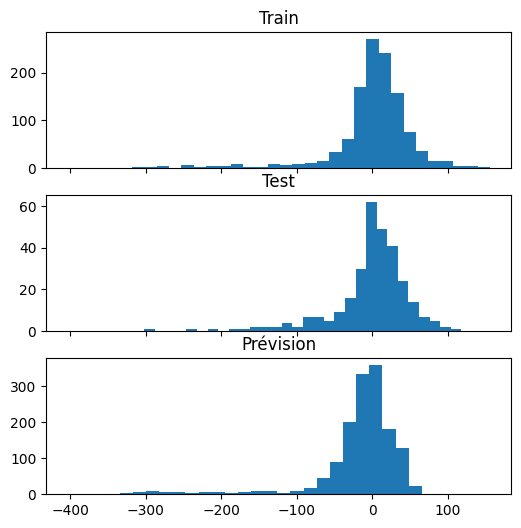

In [260]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax1.set_title('Train')
ax1.hist(y_train-y_train_pred, bins = 30)
ax2.set_title('Test')
ax2.hist(y_test-y_test_pred, bins = 30)
ax3.set_title('Prévision')
ax3.hist(df['Réel']-df['Prévision'], bins = 30)
plt.show()

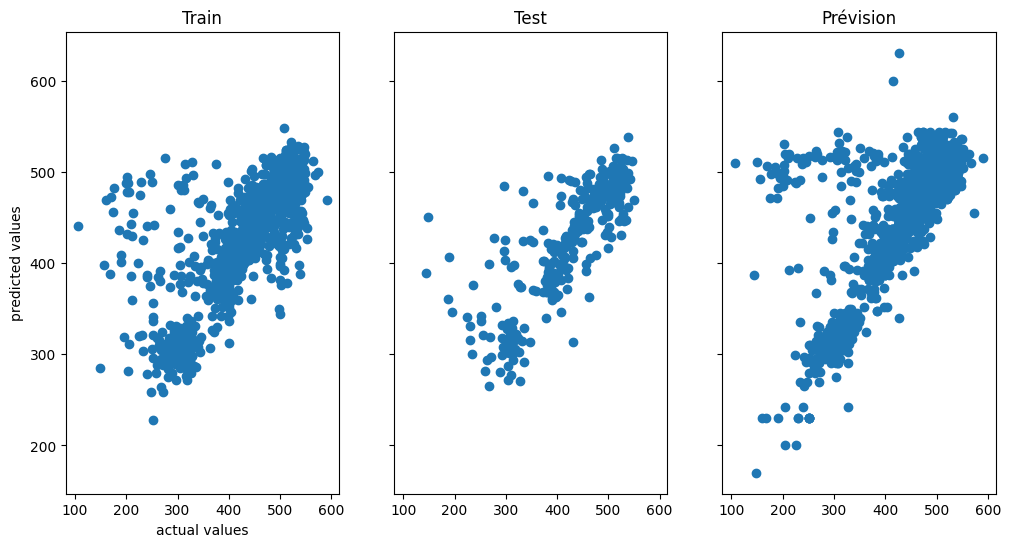

In [261]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6), sharex=True, sharey=True)
ax1.set_title('Train')
ax1.set_xlabel('actual values')
ax1.set_ylabel('predicted values')
ax1.scatter(x=y_train, y=y_train_pred)
ax2.set_title('Test')
ax2.scatter(x=y_test, y=y_test_pred)
ax3.set_title('Prévision')
ax3.scatter(x=df['Réel'], y=df['Prévision'])
plt.show()